In [1]:
%matplotlib notebook
from scipy.stats import ttest_ind
import pandas as pd
from sklearn.model_selection import cross_val_score, cross_val_predict, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
from tools import save_pickle, clean_df

In [60]:
def first_run(data_p='data/over_img.xlsx', key='original_shape_Volume'):
    if os.path.isfile('data/x_temp.xlsx') and os.path.isfile('data/y.xlsx'):
        print('Use Cache')
        x_temp = pd.read_excel('data/x_temp.xlsx', index_col=0)
        y = pd.read_excel('data/y.xlsx', index_col=0)
    else:
        data = pd.read_excel(data_p, index_col=0)
        x_temp, y = clean_df(data, key=key)
        x_temp.to_excel('data/x_temp.xlsx')
        y.to_excel('data/y.xlsx')
    return x_temp, y

### After the preparation, start from this point

In [59]:
def feature_rough_sel(data):
    bio_info = ("ASM", "Contrast", "Correlation", "Homogeneity", "Entropy", "Variance", "Skewness", "Kurtosis")
    selected_feature = list(filter_df(data, bio_info))
    return selected_feature

def clean_df(data, selected_feature=None, key='original_shape_VoxelVolume'):
    data = data.sort_index()
    # here the date is also sorted
    # from the paper [\cite] the following features may have biological meanings
    if not selected_feature:
        selected_feature = feature_rough_sel(data)
    sel_data = data.loc[:, selected_feature]
    sel_data['id'], _ = zip(*[v.split('Date') for v in sel_data.index.tolist()])

    before_data = sel_data.iloc[::2, :]
    after_data = sel_data.iloc[1::2, :]

    v_before = data.loc[before_data.index, key]
    v_after = data.loc[after_data.index, key]
    y = y_creator(v_before, v_after, before_data['id'])
    x = before_data.set_index('id')
    print(x.shape)
    return x, y

def y_creator(v_before, v_after, idxs):
    ratio = v_after.values / v_before.values
    y_change = ratio -1
    y = pd.DataFrame({'volume before':v_before.values, 'volume after':v_after.values, 'effectiveness':y_change<-0.25},
            index = idxs)
    return y

def filter_df(data, sel_info):
    # select realted columns
    func_filter = lambda x : any([info == x.split('_')[-1] for info in sel_info])
    columns = filter(func_filter, data.columns.tolist())
    return columns  

In [61]:
x_temp, y = first_run()

(66, 66)


In [62]:
def divide_df(refer_df, c):
    return refer_df.loc[refer_df[c] == 0].index, refer_df.loc[refer_df[c] == 1].index

In [63]:
def feature_selection_ttest(df, refer_df, refer_c='effectiveness'):
    """in refer dataframe, there must be a binary column which can be used to divide the data into two groups. 
    here, the change of volume is the characteristic"""
    g_noeff_idx, g_eff_idx = divide_df(refer_df, refer_c)
    print(df.columns)
    recoder = {}
    for c in df.columns:
        g_noeff = df.loc[g_noeff_idx, c].values
        g_eff = df.loc[g_eff_idx, c].values
        recoder[c] = ttest_ind(g_noeff, g_eff)
    return recoder

In [64]:
def convertor(recoder):
    df = pd.DataFrame.from_dict(recoder, orient='index').sort_values('pvalue')
    return df

In [65]:
def remove_duplicate(df_pval):
    idxs = df_pval.index.tolist()
    recoder = {}
    for idx in idxs:
        feature_type = idx.split('_')[-1]
        if not recoder.get(feature_type):
            recoder[feature_type] = idx
    return list(recoder.values())

In [66]:
def sel_pipe(x_temp, y):
    feature_selection_df = convertor(feature_selection_ttest(x_temp, y))
    # how to evaluate a certain percision
    feature_selection = feature_selection_df.loc[feature_selection_df['pvalue']<0.1]
    removed = remove_duplicate(feature_selection)
    save_pickle(removed, 'selected_feature', 'data')
    img_feature = feature_selection.loc[removed]

    data_img = x_temp.loc[:, img_feature.index]

    print('ttest for selected features')
    print(feature_selection_df.loc[removed])
    return data_img

In [67]:
x_img = sel_pipe(x_temp, y)

Index(['log-sigma-3-0-mm-3D_firstorder_Entropy',
       'log-sigma-3-0-mm-3D_firstorder_Kurtosis',
       'log-sigma-3-0-mm-3D_firstorder_Skewness',
       'log-sigma-3-0-mm-3D_firstorder_Variance',
       'log-sigma-3-0-mm-3D_glcm_Contrast',
       'log-sigma-3-0-mm-3D_glcm_Correlation',
       'log-sigma-5-0-mm-3D_firstorder_Entropy',
       'log-sigma-5-0-mm-3D_firstorder_Kurtosis',
       'log-sigma-5-0-mm-3D_firstorder_Skewness',
       'log-sigma-5-0-mm-3D_firstorder_Variance',
       'log-sigma-5-0-mm-3D_glcm_Contrast',
       'log-sigma-5-0-mm-3D_glcm_Correlation', 'original_firstorder_Entropy',
       'original_firstorder_Kurtosis', 'original_firstorder_Skewness',
       'original_firstorder_Variance', 'original_glcm_Contrast',
       'original_glcm_Correlation', 'wavelet-HHH_firstorder_Entropy',
       'wavelet-HHH_firstorder_Kurtosis', 'wavelet-HHH_firstorder_Skewness',
       'wavelet-HHH_firstorder_Variance', 'wavelet-HHH_glcm_Contrast',
       'wavelet-HHH_glcm_Correlatio

In [68]:
def train_pipe(x, y, title='Image', split=False, save=False):
    x_ori, y_ori = x, y
    if split:
        x_train, x_test, y_train, y_test = train_test_split(x_ori, y_ori, random_state=42, test_size=0.1)
        log_train(x_train, x_test, y_train, y_test)
    else:
        x_train, y_train = x_ori, y_ori
    plt.figure()
    for i in range(1, len(x_ori.columns)+1):
        if i == 1:
            plot_auc(x_train.iloc[:,:i], y_train, title=title, special=str(i)+' Feature')
        else:
            plot_auc(x_train.iloc[:,:i], y_train, title=title, special=str(i)+' Features')

In [69]:
def log_train(x_train, x_test, y_train, y_test):
    log_cls = LogisticRegression(solver='liblinear')
    log_cls.fit(x_train, y_train)
    print(roc_auc_score(y_test, log_cls.predict_proba(x_test)[:,1]))

In [70]:
def plot_auc(x, y, title='Image & Phy', special=None):
    y = np.ravel(y)
    scaler = StandardScaler()
    X_train = scaler.fit_transform(x)
#     X_train = x
    r_reg = LogisticRegression(solver='liblinear')
    y_scores = cross_val_predict(r_reg, X_train, y, cv=5,
    method="decision_function")
    fpr, tpr, thresholds = roc_curve(y, y_scores)
    score = cross_val_score(r_reg, X_train, y, scoring="roc_auc", cv=5)
    if special:
        special = '{} (area={:.3f}, std={:.3f})'.format(special, np.mean(score), np.std(score))
        
    plt.plot(fpr, tpr, linewidth=2, label=special or
             'ROC curve (area={:.3f}, std={:.3f})'.format(np.mean(score), np.std(score)))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.title(title)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
#     plt.savefig('{}.png'.format(title), dpi=300)

### clinical data

In [75]:
def x_phy_creator(phy_p='data/phy_secure.xlsx'):
    phy = pd.read_excel(phy_p, index_col=0).sort_index()
    phy.index = phy.index.astype(str)
    phy_pval_df = convertor(feature_selection_ttest(phy, y))
    print(phy_pval_df[:5])
    x_phy = phy.loc[:, ['BUN', 'PK']]
    return x_phy

In [76]:
x_phy = x_phy_creator()

Index(['AST', 'ALT', 'NA.', 'BUN', 'Crea', 'Uricacid', 'Glu', 'Chol', 'Gly',
       'HDL', 'LDL', 'ApoA1', 'ApoB', 'X.Albumin', 'PK', 'hs.CRP', 'NPC',
       'relapse', 'T', 'N', 'Npdose', 'NPtimes', 'Npdays', 'Neckdose',
       'Necktimes', 'Neckdays', 'preRC', 'currentRC'],
      dtype='object')
           statistic    pvalue
LDL         1.412338  0.162695
BUN        -1.241916  0.218800
PK         -1.203833  0.233088
Necktimes  -1.178301  0.243039
Neckdose   -1.178301  0.243039


In [77]:
def show_pipe(x_img, x_phy, y):
    y = y['effectiveness']
    train_pipe(x_img, y, title='Image')
    plt.figure()
    plot_auc(x_img, y, title='Image', special='Image')
    plot_auc(x_phy, y, title='Clinical', special='Clinical Data')
    plot_auc(x_img.merge(x_phy, left_index=True, right_index=True), y, special='Image & Clinical Data')

<IPython.core.display.Javascript object>


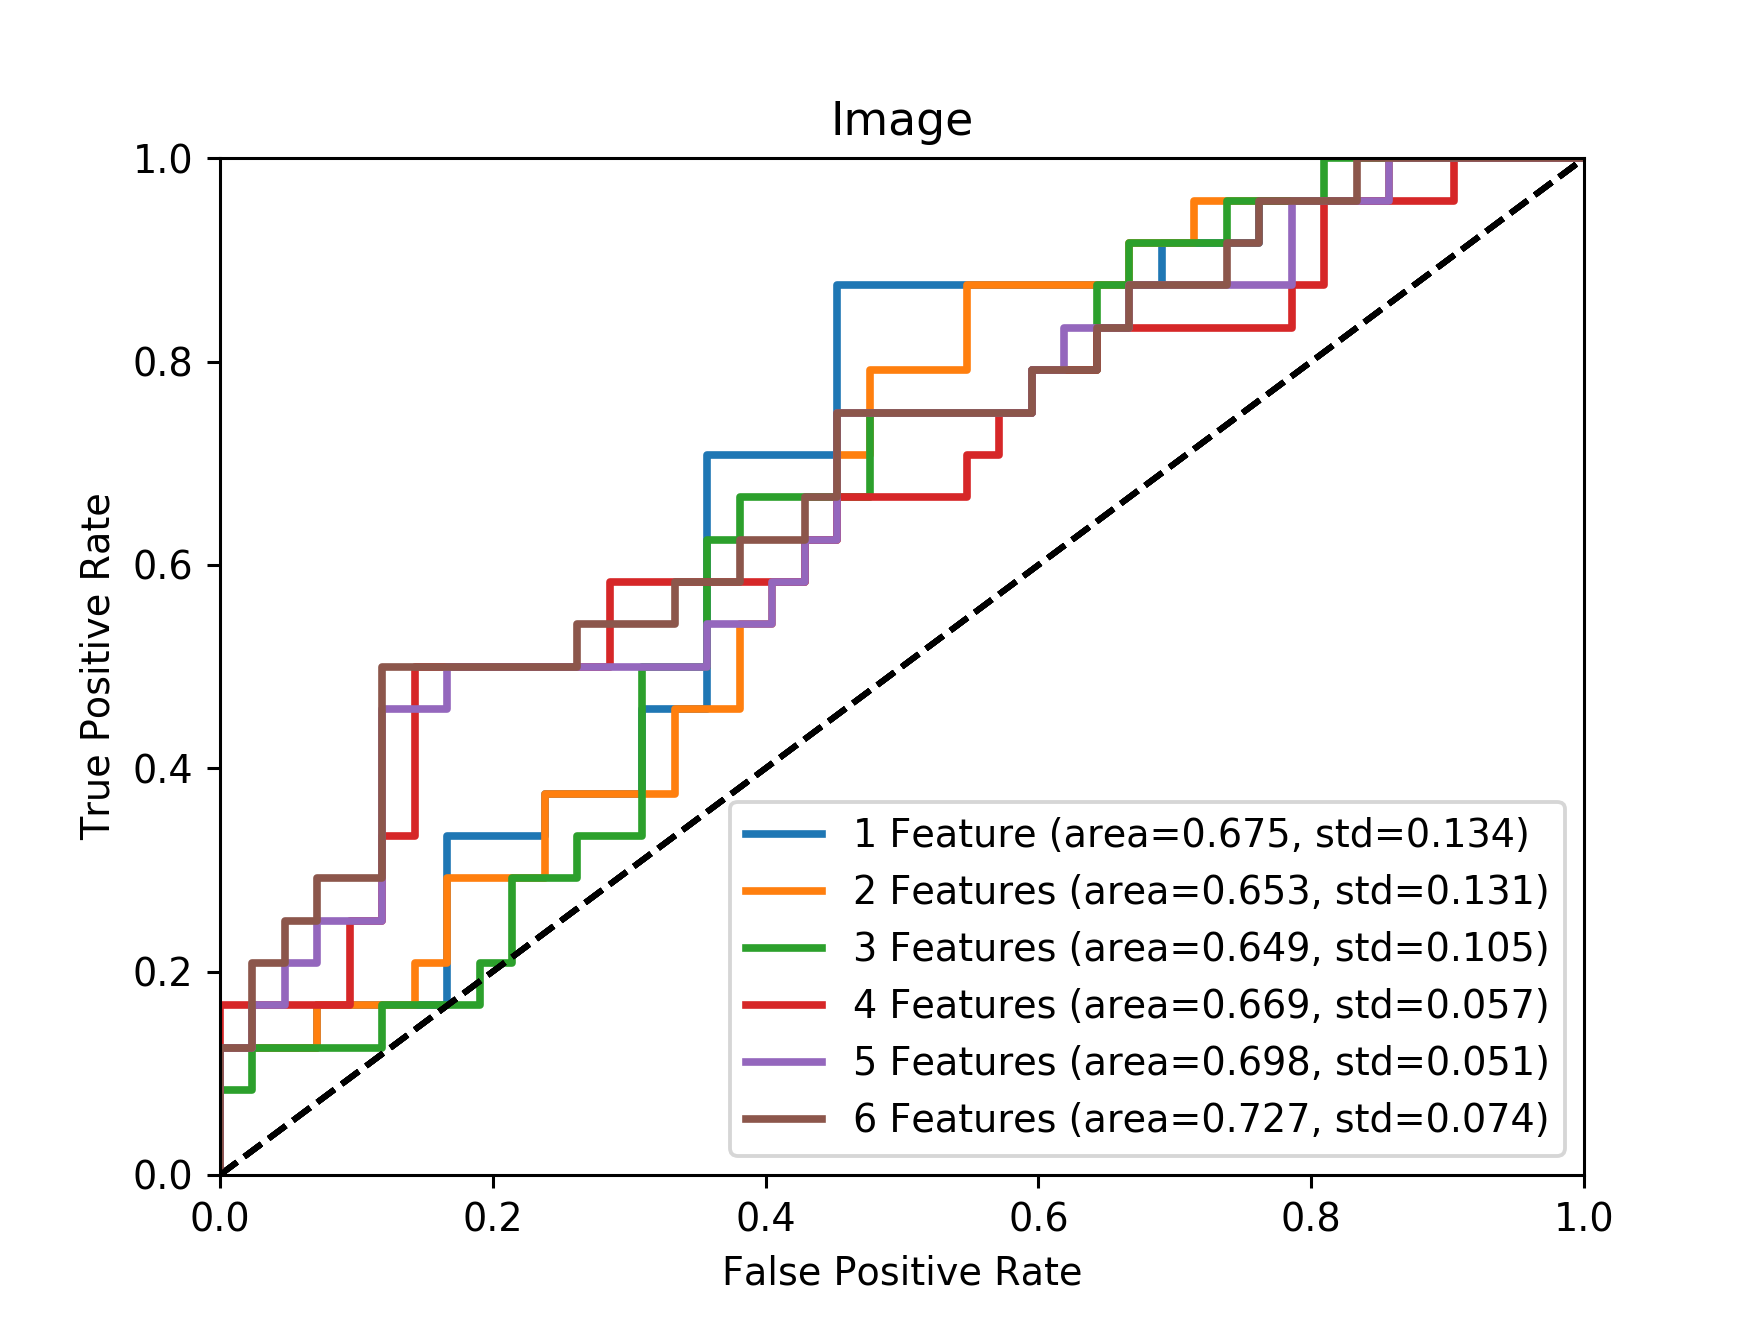

<IPython.core.display.Javascript object>


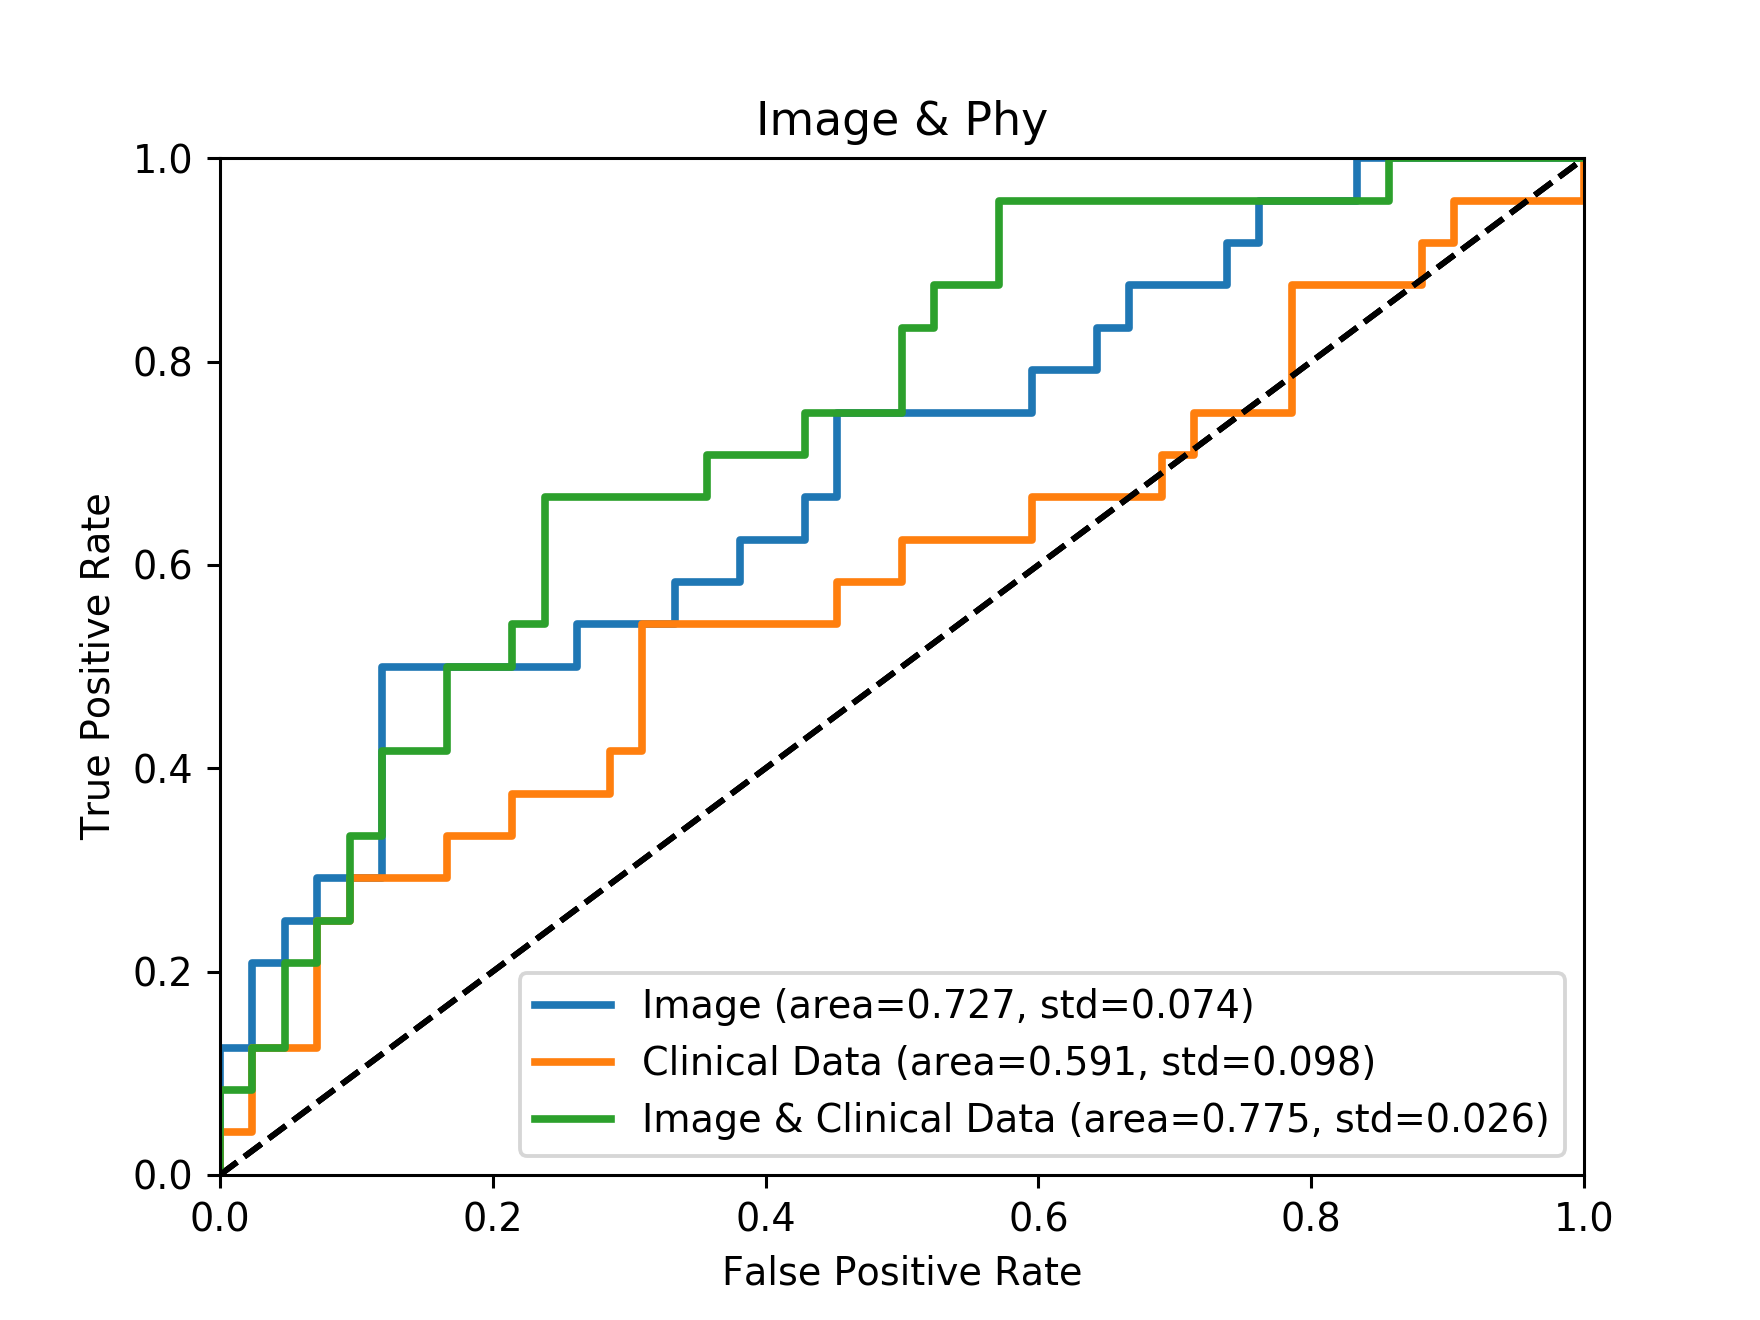

D:\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
D:\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
D:\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
D:\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [78]:
show_pipe(x_img, x_phy, y)